This notebook loads tif files from a 'confinement' experiment, fits the data to obtain a diffusion coefficient. 

Last ran on kafka 


In [2]:
#!pip3 install pims trackpy

In [34]:
import sys 

from matplotlib import rcParams 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from pandas import DataFrame, Series  # for convenience 
 
import pims 
import trackpy as tp

In [35]:
fr = 90 # s/fr # experiment

NOTE: 90s per frame/not sure how this is reflected below 

* <font color=red>
I believe Xuan coded this part up. I don't know where some of the values come from, so these should be elaborated. In particular, is time1 the same for all cells? </font color>
* Is the reporting a single cell or all of them? Would like to report std error for the exptl msds

In [36]:


# tracking 
def DoTracking(frames):
    fb = [] 
    #rcParams['figure.figsize']=10,10 
    for i in np.arange(len(frames)): # I think this should only have 1 at a time
        diameter=41
        f = tp.batch(frames[i], diameter, minmass=1e2) # dunno what '39' is
        tp.annotate(f, frames[i][0]) # not sure what this one is about 
        fb.append(f)
    return fb
    
def DoMSD(fb,imageName=None):    
    firstCell = None
    maxDist=25 # maximum displacement in pixel # was 45
    maxMissFrame=200 # do not forget disappeared particles unless they've dis

    rcParams['figure.figsize']=7,7 
    msd = [] 
    ct = 0
    for j,f in enumerate(fb): 
        t = tp.link(f, maxDist, memory=maxMissFrame) 
        t1 = tp.filter_stubs(t,50) 
        d = tp.compute_drift(t1) 
        tm = tp.subtract_drift(t1.copy(), d) 
        davg = np.mean(d,axis=0)
        print("D avg/all frames\n",davg)
        em = tp.emsd(tm, 1.63, 1/30) 

        ct+=1 
        if j == 0: 
            time1 = [] 
            for i in em.index: 
                time1.append(i) 

            data = [] 
            for i in em.values: 
                data.append(i) 
            firstCell = np.array( data )

        else: 

            data_new = [] 
            for i in em.values: 
                data_new.append(i) 

            data = np.asarray(data)+np.asarray(data_new) 


    print("Double check, data contains ALL particle trajectories? (%d)"%ct)         

    plt.figure()
    plt.plot( time1,firstCell )
    plt.xlabel('sec')
    plt.ylabel('um**2')

    plt.figure()
    tp.plot_traj(t1)
    if imageName is not None:
        plt.gcf().savefig(imageName )
    
    return time1,t1, data


def DoFit(frames,time1,data):
    from scipy import stats 


    v = np.asarray( data )
    #print(np.shape(v))
    data = v

    #print(data)
    print("NEED TO FIX, this is not a good way of doing this")
    numTraj = len(frames)
    dataavg1=data/numTraj


    res1 = stats.linregress(time1,dataavg1) 
    print(f"R-squared: {res1.rvalue**2:.6f}") 
    print("Slope: ",res1.slope) 
    print("Intercept: ",res1.intercept)

    D = res1.slope/4

    x1 = np.arange(3000)
    plt.figure(figsize=(6,4),dpi=150)
    plt.plot(time1,dataavg1,'b:',alpha=0.5,label='0 mM - Expt.')
    
    plt.plot(x1,res1.intercept + res1.slope*x1,'b',
             label=str('%.3f'%(res1.slope))+"x+"+str('%.3f'%(res1.intercept))+' D='+str('%.4f'%(D)))

    plt.legend(loc=0)
    plt.xlabel("Time [sec]")
    plt.ylabel("MSD [um**2]")
    plt.tight_layout()
    
    return D,dataavg1

    
def DoSave(time1,dataavg1,fileName="expt_noatp.csv"):    
    import numpy
    outData = np.zeros_like(np.outer(time1,[0,0]))
    outData[:,0]=time1
    outData[:,1]=dataavg1

    np.savetxt(fileName,outData)

    
    
def CalcDistances(t1):
    particles = np.unique(t1['particle'])

    minFrames = 300
    dists = []
    for particleNum in particles:
      subDF = t1.loc[t1['particle'] == particleNum]
      #subDF.loc[0]
      daMin = subDF['frame'].min()
      daMax = subDF['frame'].max()

      if daMin>0 or (daMax-daMin)<minFrames:
            next

      xi = subDF.loc[daMin].x
      yi = subDF.loc[daMin].y
      xf = subDF.loc[daMax].x
      yf = subDF.loc[daMax].y

      dist = (xf-xi)**2 + (yf-yi)**2
      dist = np.sqrt(dist)
      #dist = xf-xi
      dists.append( dist)
    
    return dists    

### No ATP 

Not sure how this naming scheme was decided upon 

In [37]:
# former path
path='/home/pkh-lab-shared/ekrueger2/microscopy_data/Confinement/confinement_data_11_14_22/'
# new path (rsync'd a local copy)
# rsync -ah /home/echo_nfs/microscopy_data/11_14_22_confinement/confinement_data_11_14_22 $KAFKA:/u1/pkekeneshuskey/delme/
#path='/u1/pkekeneshuskey/delme/confinement_data_11_14_22/'
path="/u1/pkekeneshuskey/delme/confinement_data_12_12_22/xxxx/"

treatment=['11']
    
#density = ['A']
#fld = ['1','2','3'] 
#ATPno = ['1','2'] 


filenames_confinement = [] 
 
#for condition in treatment:
#    filenames_confinement.append(path+'Capture1-'+condition+'_XY0_Z0_T000_C0.tif')
filenames_confinement.append(path+'Capture1-Position6_noATP_unconfined_XY1670892965_Z0_T000_C0.tif')
#for dens in density: 
    #for f in fld: 
        #for ATP in ATPno: 
            #filenames_confinement.append(dens+ATP+'_fld'+f+'.tiff') 
#print(filenames_confinement)            

caseNames = ["-ATP" for x in range(len(filenames_confinement))]
#print(caseNames)

### With ATP 

In [38]:
# with atp? 
filenames_confinement_ATP=[]  

# they're from the experiments on 12/12/22. here is the pathway for that folder: 
# "/home/echo_nfs/microscopy_data/12_12_22_confinement/confinement_data_12_12_22/"
# rsync -ah /home/echo_nfs/microscopy_data/12_12_22_confinement/confinement_data_12_12_22 $KAFKA:/u1/pkekeneshuskey/delme/


# they're named based on being confined/unconfined and ATP/noATP
file="Capture1-Position12_ATP_unconfined_XY1670892971_Z0_T000_C0.tif"

filenames_confinement_ATP.append(path+file)
caseNamesATP = ["+ATP" for x in range(len(filenames_confinement_ATP))]
#print(casesATP)

filenames_confinement =  filenames_confinement + filenames_confinement_ATP
caseNames = caseNames + caseNamesATP


### Load images 

In [39]:
cases = dict()
class empty:pass

Frame 320: 165 trajectories present.
D avg/all frames
 y    2.956578
x    0.340343
dtype: float64
Double check, data contains ALL particle trajectories? (1)


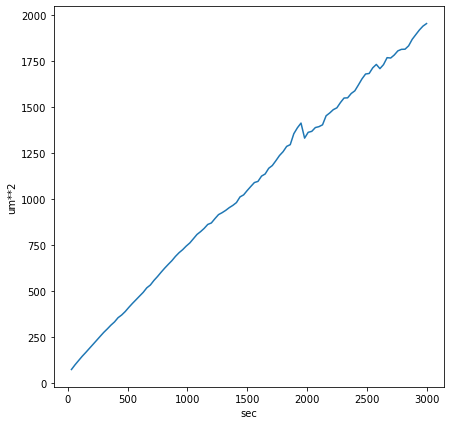

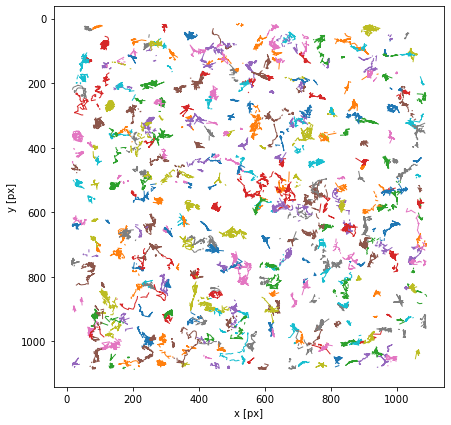

NEED TO FIX, this is not a good way of doing this
R-squared: 0.997880
Slope:  0.6242596109315236
Intercept:  103.2045375682793


<Figure size 504x504 with 0 Axes>

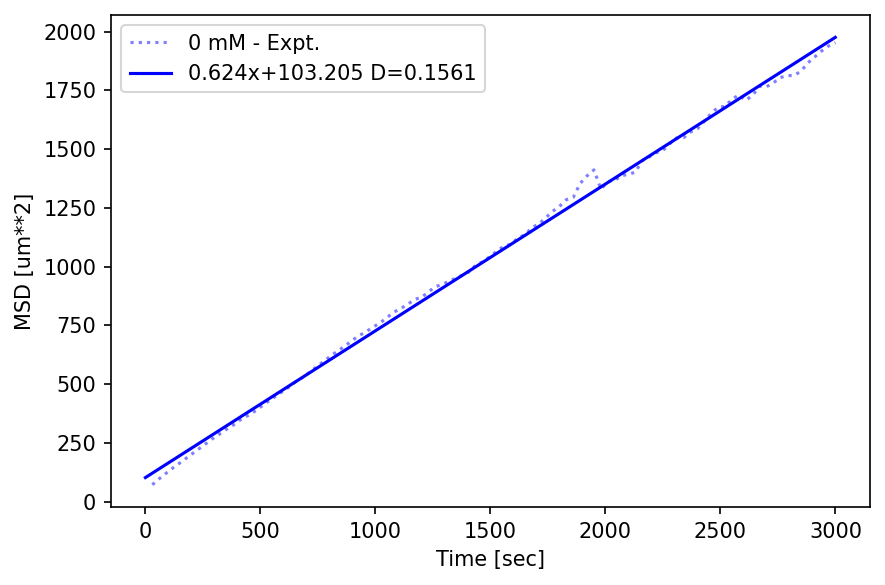

In [40]:

#filename =filenames_confinement[0]
#filename =filenames_confinement[1]
for i,filename in enumerate(filenames_confinement): 
#i=0
#filename = filenames_confinement[i]
#if 1:
    print("Processing ",filename)
    # NOT QUITE SURE WHY FRAMES IS USED HERE 
    frames = [] 
    frame = pims.open(filename) 
    frames.append(frame) 
    
    
    # load frame 
    v = np.array( frame ) 
    frame_i=v[:,:,:]
    print( np.shape(frame_i) )

    # display frame 
    plt.pcolormesh( np.flipud( frame_i[0,:,:] ), cmap='gray')


    # big steps 
    plt.figure()
    fb = DoTracking(frames)
    time1,t1, data = DoMSD(fb,caseNames[i]+".png")
    D,dataavg1 = DoFit(frames,time1,data)
    dists = CalcDistances(t1)
    DoSave(time1,dataavg1)
    
    # store data 
    case = empty()
    case.time1 = time1
    case.dataavg1 = dataavg1
    case.D = D 
    case.dists = dists
    case.frame = frame
    
    cases[caseNames[i]] = case 


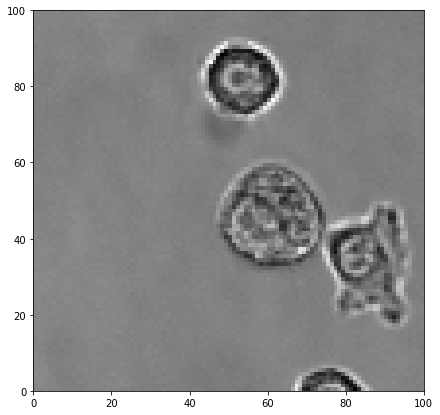

In [41]:
frame_i=v[0,100:200,350:450]

plt.pcolormesh(frame_i,cmap='gray')


Text(0, 0.5, 'Prob')

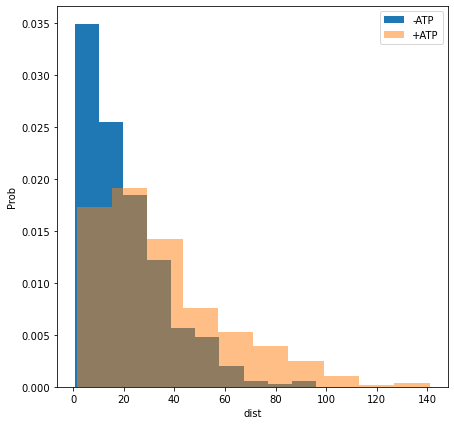

In [42]:
caseName='-ATP'
case = cases[caseName]
plt.hist(case.dists,density=True,label='-ATP')

caseName='+ATP'
case = cases[caseName]
plt.hist(case.dists,alpha=0.5,density=True,label='+ATP')
plt.legend(loc=0)
plt.xlabel("dist")
plt.ylabel("Prob")

* Tests
```
cd tests
```
* Run (kafka) 
```
python3 ../brownian_v3.py -yamlFile expt.yaml -run
```
* Process
```
python3 batchProcess.py -single expt # kant for now
```
* upload expt.csv



In [43]:
simFile = "expt.csv"
simData = np.loadtxt(simFile)

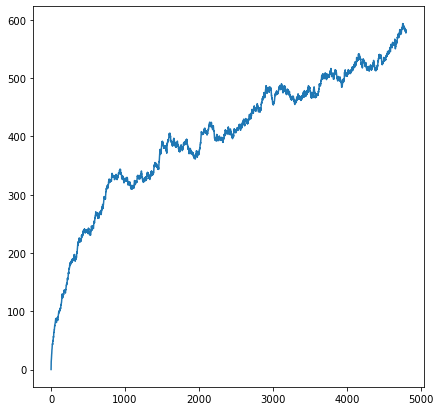

In [44]:
plt.plot(simData[:,0],simData[:,1])

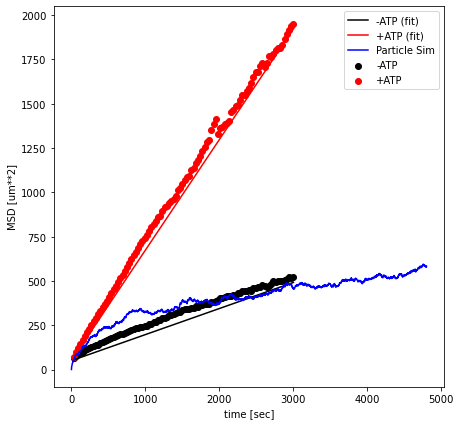

In [45]:
caseName = '-ATP'
case = cases[caseName]
plt.scatter(case.time1,case.dataavg1,facecolor='k',label=caseName)
msd = np.array(case.time1)*4*case.D + 50
plt.plot(case.time1, msd,'k',label=caseName+" (fit)")


caseName = '+ATP'
case = cases[caseName]
plt.scatter(case.time1,case.dataavg1,facecolor='r',label=caseName)
msd = np.array(case.time1)*4*case.D + 50
plt.plot(case.time1, msd,color='r',label=caseName+" (fit)")

plt.plot(simData[:,0],simData[:,1],color='b',label="Particle Sim")


plt.xlabel("time [sec]")
plt.ylabel("MSD [um**2]")
plt.legend(loc=0)
plt.gcf().savefig("msd.png",dpi=300)

In [49]:
msd[9]

206.09947014256585